In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
# from mpl_toolkits.axisartist.axislines import AxesZero
from scipy import signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [9]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [10]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [11]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [12]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load subjects from file

In [13]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\EEG-LFP'

## Choose example subjects and load experiment

In [15]:
example_mice = {
    'MOs_superficial': '571619',
    'MOs_deep': '569073',
    'SSp_superficial': '590480',
    'SSp_deep': '590480'
}

In [16]:
ex_sub_dict = {x: {} for x in example_mice.keys()}
for group, mouse in example_mice.items():
    print('{} - {}'.format(group, mouse))
    ex_sub_dict[group][mouse] = multi_sub_dict[group][mouse]
    ex_sub_dict[group][mouse]['exp'] = EEGexp(multi_sub_dict[group][mouse]['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial - 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep - 569073
Experiment type: electrical and sensory stimulation

SSp_superficial - 590480
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

SSp_deep - 590480
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.



## Gather data for example subjects

In [17]:
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
apply_car = True
downsampleEEG = True
subsampling_factor = 2
current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [18]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        if downsampleEEG:
            EEG_event_timestamps = EEG_event_timestamps[::subsampling_factor]
            all_EEG_traces = signal.decimate(all_EEG_traces, subsampling_factor, ftype='iir', axis=0, zero_phase=True)
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        mdata['LFP_info'] = LFPinfo
            
        ## Load regional stuff ##
        reg_allLFPtraces = {}
        for region in areas_of_interest.keys():
            if region in LFPinfo.keys():
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
        print('  Getting event-related traces (EEG and LFP)...')
        EEG_traces = {}
        LFP_traces = {}
        for leveli, parami in zip(current_levels, currents_list):
            EEG_traces[leveli] = {}
            LFP_traces[leveli] = {}

            for statei in test_states:
                LFP_traces[leveli][statei] = {}
                
                sweeps = mdata['states'][statei]
                if sweeps:
                    state_event_inds = []
                    for sweepi in sweeps:
                        eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                        if len(eventinds) == 0:
                            continue
                        state_event_inds.append(eventinds)
                    state_event_inds = np.concatenate(state_event_inds)

                    ## Get evoked EEG traces ##
                    event_traces = all_EEG_traces[:, :, state_event_inds]
                    ## Apply common avg ##
                    if apply_car:
                        event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                    EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]

                    for region in areas_of_interest.keys():
                        ## Get evoked LFP traces ##
                        if region in reg_allLFPtraces.keys():
                            LFP_traces[leveli][statei][region] = [
                                LFP_event_ts, reg_allLFPtraces[region][:, :, state_event_inds]]

        mdata['data']['EEG'] = EEG_traces
        mdata['data']['LFP'] = LFP_traces
        
        ### After each subject, delete common variables ###
        del stim_log, all_EEG_traces, EEG_event_timestamps, reg_allLFPtraces, LFP_event_ts, LFPinfo, EEG_traces, LFP_traces
    print('')

MOs_superficial

 571619
  Getting event-related traces (EEG and LFP)...

MOs_deep

 569073
  Getting event-related traces (EEG and LFP)...

SSp_superficial

 590480
  Getting event-related traces (EEG and LFP)...

SSp_deep

 590480
  Getting event-related traces (EEG and LFP)...



## Exploring correlations between EEG and LFP (layer 1 and others)

Notes from Christof:
- Use Spearman's correlation too (report both)
- What happens in non-stim cortical areas?

In [35]:
group = 'MOs_deep'
mouse_num = '569073'
mdata = ex_sub_dict[group][mouse_num]
plevel = 'medium'
pstate = 'awake'

regi = 'MO'
chi = 11 # ch 13 is closer to MO probe, but is bad
layer = '5'

GOOD_CHS = ex_sub_dict[group][mouse_num]['good_chs']
if chi not in GOOD_CHS:
    print('Chosen ch {:d} is a bad channel'.format(chi))
EEGtime = ex_sub_dict[group][mouse_num]['data']['EEG'][plevel][pstate][0]
EEG_traces = ex_sub_dict[group][mouse_num]['data']['EEG'][plevel][pstate][1][:,chi,:] / 1E3
print(EEG_traces.shape)

LFPinfo = ex_sub_dict[group][mouse_num]['LFP_info'][regi]
Lmask = np.array([True if layer in x else False for x in LFPinfo['ch_areas']])
LFPtime = ex_sub_dict[group][mouse_num]['data']['LFP'][plevel][pstate][regi][0]
LFP_traces = ex_sub_dict[group][mouse_num]['data']['LFP'][plevel][pstate][regi][1][:,Lmask,:] / 1E3
print(LFP_traces.shape)

(5000, 86)
(5000, 42, 86)


<IPython.core.display.Javascript object>


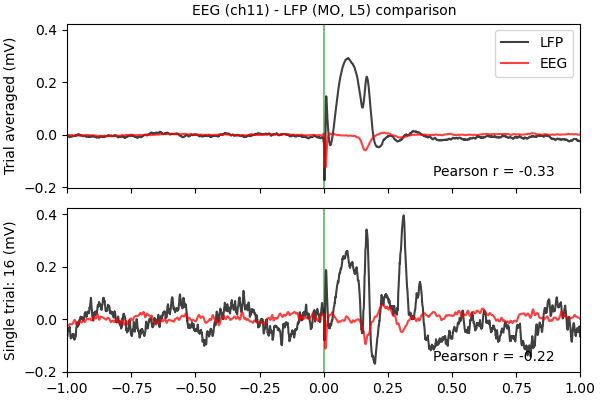

In [36]:
pwin = [-1.0, 1.0]
triali = 16

fig, axs = plt.subplots(2, 1, figsize=(6,4), sharex=True, sharey=True, constrained_layout=True)
# Plot trial average #
eegavg = np.mean(EEG_traces, axis=1)
lfpavg = np.mean(np.mean(LFP_traces, axis=2), axis=1)
pr_avg, pp_avg = stats.pearsonr(eegavg, lfpavg)
axs[0].axvline(0, color='g', alpha=0.5)
axs[0].plot(LFPtime, lfpavg, 'k', linewidth=1.5, alpha=0.75, label='LFP')
axs[0].plot(EEGtime, eegavg, 'r', linewidth=1.5, alpha=0.75, label='EEG')
axs[0].annotate(
    'Pearson r = {:.2f}'.format(pr_avg), xy=(0.95, 0.05), xycoords='axes fraction', fontsize=10, ha='right', va='bottom'
)
axs[0].set_ylabel('Trial averaged (mV)')
axs[0].legend()

# Plot single trial #
eegsing = EEG_traces[:,triali]
lfpsing = np.mean(LFP_traces[:,:,triali], axis=1)
pr_sing, pp_sing = stats.pearsonr(eegsing, lfpsing)
axs[1].axvline(0, color='g', alpha=0.5)
axs[1].plot(LFPtime, lfpsing, 'k', linewidth=1.5, alpha=0.75)
axs[1].plot(EEGtime, eegsing, 'r', linewidth=1.5, alpha=0.75)
axs[1].annotate(
    'Pearson r = {:.2f}'.format(pr_sing), xy=(0.95, 0.05), xycoords='axes fraction', fontsize=10, ha='right', va='bottom'
)
axs[1].set_ylabel('Single trial: {:d} (mV)'.format(triali))

axs[0].set_title('EEG (ch{:d}) - LFP ({}, L{}) comparison'.format(chi, regi, layer))
axs[0].set_xlim(pwin)

## Save ##
figname = 'traceplot_{}_{}_{}{}_ch{:d}.png'.format(group, mouse_num, regi, layer, chi)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

In [21]:
eegavg = np.mean(EEG_traces, axis=1)
lfpavg = np.mean(np.mean(LFP_traces, axis=2), axis=1)

pearson_r, pearson_p = stats.pearsonr(eegavg, lfpavg)
print('Pearson correlation between EEG and LFP:\nr = {:.2f}, p = {:.4E}'.format(pearson_r, pearson_p))

Pearson correlation between EEG and LFP:
r = 0.64, p = 0.0000E+00


In [22]:
eegsing = EEG_traces[:,triali]
lfpsing = np.mean(LFP_traces[:,:,triali], axis=1)

pr_sing, pp_sing = stats.pearsonr(eegsing, lfpsing)
print('Pearson correlation between EEG and LFP:\nr = {:.2f}, p = {:.4E}'.format(pr_sing, pp_sing))

Pearson correlation between EEG and LFP:
r = 0.38, p = 1.7090E-173
